# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [ ]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from scipy.signal.windows import hann


from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [ ]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.int(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

# Load the signal

In [ ]:
sound = 'aeiou.wav'
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [ ]:
IPython.display.Audio('aeiou.wav')

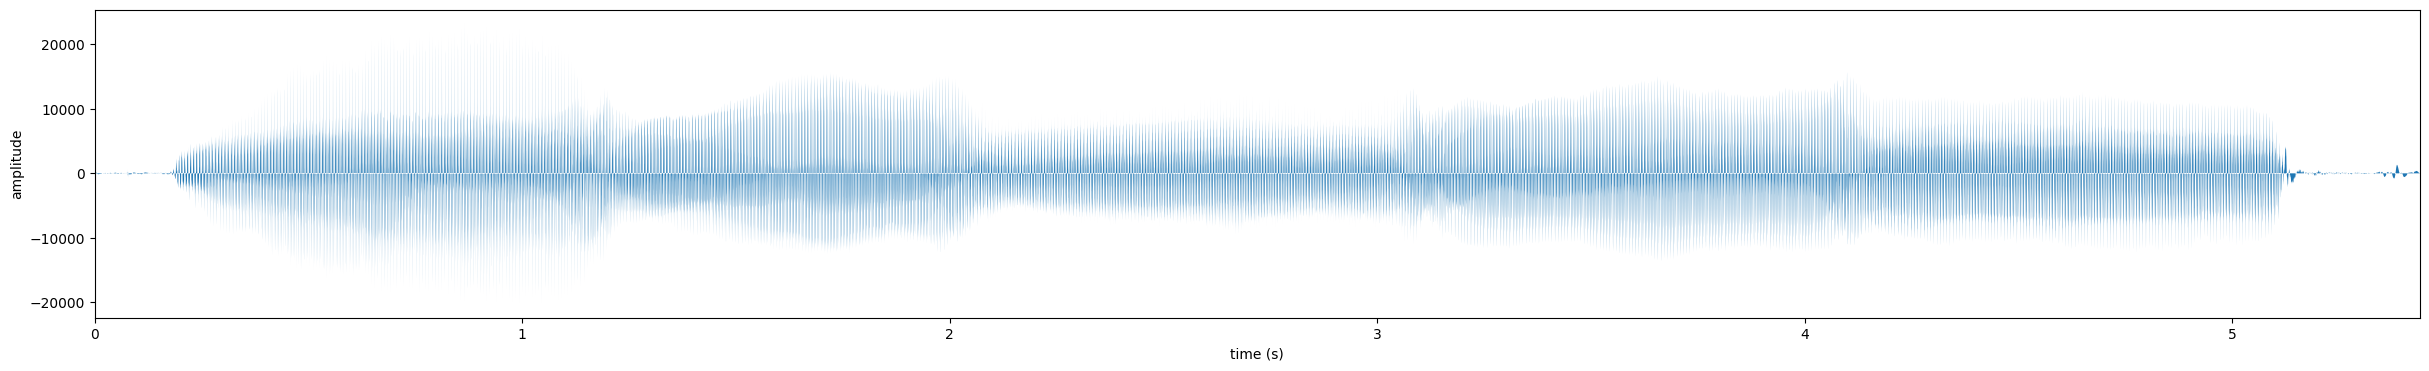

In [ ]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

# 1. Extraction of the analysis marks

In [ ]:
def AnalysisPitchMarks(s, Fs):

  P, voiced = period(s, Fs)
  a0 = []
  a1 = []
  a2 = []

  # Initialisation
  P_n_1 = 1e-2 * Fs
  t_n_1 = 0
  start = 0
  end = start + P_n_1
  
  while end < len(s):

    duration = 2.5 * P_n_1
    end = int(start + duration)
    pitch = s[start:end]
    P_n, voiced_n = period(pitch, Fs)
    t_n = int(t_n_1 + P_n)

    a0.append(t_n)
    a1.append(voiced_n)
    a2.append(P_n)

    # Update 
    start = int(start + P_n_1)
    P_n_1 = P_n
    t_n_1 = t_n
  
  A =  np.zeros((3, len(a1)))
  A[0] = np.asarray(a0)
  A[1] = np.asarray(a1)
  A[2] = np.asarray(a2)
  
  return A

In [ ]:
A = AnalysisPitchMarks(x, Fs)

# 2. Synthesis and modification of the temporal and spectral scales

## 2.1. Signal synthesis

In [ ]:
def Synthesis(s, Fs, A, B):
  
  leny = int(B[0, -1]) + int(A[2, int(B[1, -1])])
  y = np.zeros(leny)

  for k in range(B.shape[1]):

    n_k = int(B[1, k])
    ta = int(A[0, n_k])
    P = int(A[2, n_k])
    pitch = s[ta-P: ta+P+1]
    hann_window = hann(len(pitch))
    pitch = pitch * hann_window

    ts = int(B[0, k])
    y[ts-P: ts+P+1] += pitch[:len(y[ts-P: ts+P+1])]
  
  return y

## 2.2. Modification of the temporal scale

In [ ]:
def ChangeTimeScale(alpha, A, Fs):
  
  # Initialisation
  t_n_1 = 0
  n_1 = 0
  b0 = [t_n_1]
  b1 = [n_1]
  while n_1 + 1/alpha < A.shape[1]:
    t_n = t_n_1 + A[2, int(n_1)]
    n = n_1 + 1/alpha

    b0.append(int(t_n))
    b1.append(int(n))

    n_1 = n
    t_n_1 = t_n
  
  B = np.zeros((2, len(b0)))
  B[0] = np.asarray(b0)
  B[1] = np.asarray(b1)

  return B

In [ ]:
B = ChangeTimeScale(2, A, Fs)

## 2.3. Modification of the spectral scale

In [ ]:
def ChangePitchScale(beta, A, Fs):

  t_n_1 = 0
  n_1 = 0
  b0 = [t_n_1]
  b1 = [n_1]
  
  while n_1 < A.shape[1]:
    if A[1, int(n_1)]:
      scale = 1/beta
    else:
      scale = 1

    t_n = t_n_1 + scale * A[2, int(n_1)]
    n = n_1 + scale 

    if n < A.shape[1]:
      b0.append(int(t_n))
      b1.append(int(n))

    n_1 = n
    t_n_1 = t_n
  
  B = np.zeros((2, len(b0)))
  B[0] = np.asarray(b0)
  B[1] = np.asarray(b1)

  return B

In [ ]:
B = ChangePitchScale(2, A, Fs)

## 2.4. Joint modifaction of the temporal and spectral scales

In [ ]:
def ChangeBothScales(alpha, beta, A, Fs):

  t_n_1 = 0
  n_1 = 0
  b0 = [t_n_1]
  b1 = [n_1]

  while n_1 < A.shape[1]:
    if A[1, int(n_1)]:
      scale = 1/beta
    else:
      scale = 1

    t_n = t_n_1 + scale * A[2, int(n_1)]
    n = n_1 + scale * (1/alpha)

    if n < A.shape[1]:
      b0.append(int(t_n))
      b1.append(int(n))

    n_1 = n
    t_n_1 = t_n
  
  B = np.zeros((2, len(b0)))
  B[0] = np.asarray(b0)
  B[1] = np.asarray(b1)

  return B

# Test

## Change time scale

In [ ]:
B = ChangeTimeScale(6, A, Fs)
y = Synthesis(x, Fs, A, B)
write('aeiou_time_changed.wav', Fs, np.array(y, dtype=np.int16)) # to write a new wave file
IPython.display.Audio('aeiou_time_changed.wav')

## Change pitch scale

In [ ]:
B = ChangePitchScale(20, A, Fs)
y = Synthesis(x, Fs, A, B)
write('aeiou_pitch_changed.wav', Fs, np.array(y, dtype=np.int16)) # to write a new wave file
IPython.display.Audio('aeiou_pitch_changed.wav')

## Change both scales

In [ ]:
B = ChangeBothScales(2, 20, A, Fs)
y = Synthesis(x, Fs, A, B)
write('aeiou_both_changed.wav', Fs, np.array(y, dtype=np.int16)) # to write a new wave file
IPython.display.Audio('aeiou_both_changed.wav')

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [ ]:
#data_path = os.getcwd()
#filename = 'aeiou.wav'
#sound = os.path.join(data_path, filename) 

sound = 'aeiou.wav'


### **Using wave**

In [ ]:
sound = 'aeiou.wav'
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [ ]:
IPython.display.Audio('aeiou.wav')

In [ ]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [ ]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

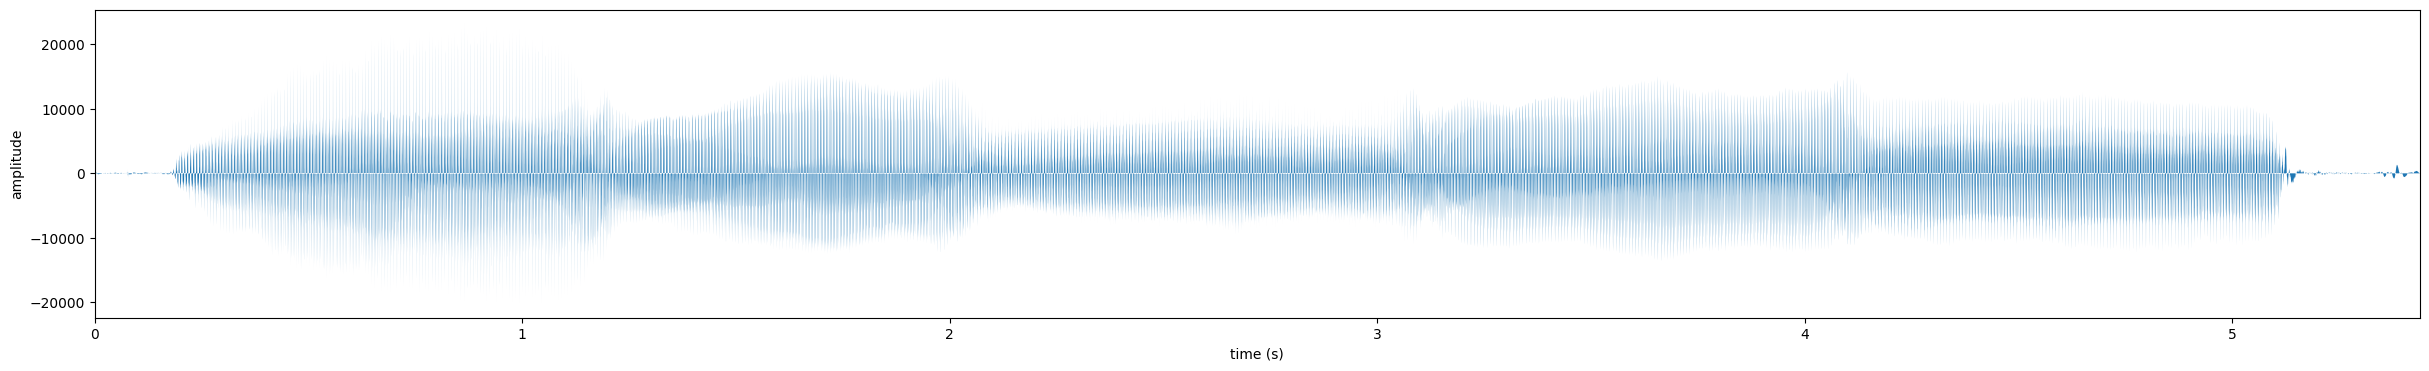

In [ ]:
plot_sound(x, times)

In [ ]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file